# AI-Based Market Trend Analysis 

## Problem Definition & Objective

Financial markets are highly volatile and influenced by both quantitative price movements and qualitative news sentiment.
The objective of this project is to design an AI-based market trend analysis system that predicts short-term BUY or SELL signals
by combining machine learning, technical indicators, and sentiment analysis.

The system aims to support decision-making rather than provide financial advice.


## Selected Project Track

This project falls under the **AI for Finance / Market Intelligence** track,
focusing on predictive analytics, technical indicators, and sentiment-based decision support systems.


In [1]:
%pip install yfinance pandas numpy matplotlib scikit-learn nltk


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3.13 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

nltk.data.path.append('/Users/NKV.Manasa/nltk_data')
nltk.download('vader_lexicon', quiet=True)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1032)>


In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

lexicon_path = "/Users/NKV.Manasa/nltk_data/sentiment/vader_lexicon.txt"
sia = SentimentIntensityAnalyzer(lexicon_file=lexicon_path)

sia.polarity_scores("Apple stock rises after strong earnings")


{'neg': 0.0, 'neu': 0.602, 'pos': 0.398, 'compound': 0.5106}

In [4]:
# Loading real Apple stock market data from CSV

data = pd.read_csv("AAPL.csv")

data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

data.head()


,Date,Open,High,Low,Close,Volume
251,2025-01-10,240.01,240.16,233.00,236.85,"61,710,859"
250,2025-01-13,233.53,234.67,229.72,234.40,"49,630,727"
249,2025-01-14,234.75,236.12,232.47,233.28,"39,435,289"
248,2025-01-15,234.64,238.96,234.43,237.87,"39,831,969"
247,2025-01-16,237.35,238.01,228.03,228.26,"71,759,047"


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 251 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Open    252 non-null    float64       
 2   High    252 non-null    float64       
 3   Low     252 non-null    float64       
 4   Close   252 non-null    float64       
 5   Volume  252 non-null    object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 13.8+ KB


In [6]:
data.describe()

,Date,Open,High,Low,Close
count,252,252.00000,252.000000,252.000000,252.000000
mean,2025-07-11 06:22:51.428571392,232.44500,235.122222,230.015714,232.616508
min,2025-01-10 00:00:00,171.95000,190.340000,169.210000,172.420000
25%,2025-04-10 18:00:00,209.98250,212.070000,207.675000,210.017500
50%,2025-07-12 12:00:00,229.98500,232.770000,227.645000,230.005000
75%,2025-10-09 06:00:00,255.38500,257.700000,253.822500,256.180000
max,2026-01-09 00:00:00,286.20000,288.620000,283.300000,286.190000
std,NaN,26.94985,26.637098,27.057131,26.846047


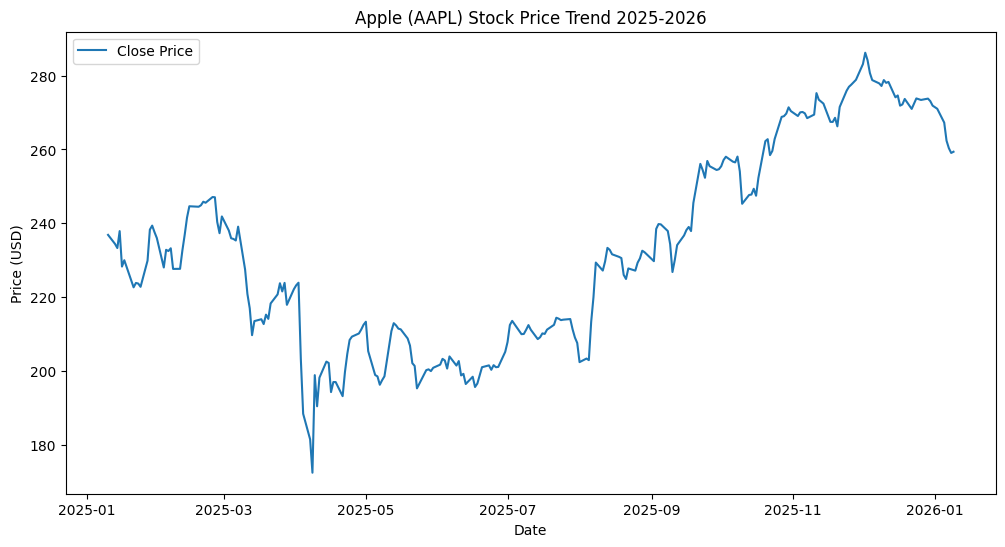

In [7]:
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.title('Apple (AAPL) Stock Price Trend 2025-2026')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [8]:
# Feature Engineering

data['Daily_Return'] = data['Close'].pct_change() # Daily percentage return

# Moving averages
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()

data = data.dropna()

data.head()


,Date,Open,High,Low,Close,Volume,Daily_Return,MA_10,MA_50
202,2025-03-24,221.00,221.48,218.58,220.73,"44,299,480",0.011270,215.602,231.4796
201,2025-03-25,220.77,224.10,220.08,223.75,"34,493,578",0.013682,215.893,231.2176
200,2025-03-26,223.51,225.02,220.47,221.53,"34,532,660",-0.009922,216.348,230.9602
199,2025-03-27,221.39,224.99,220.56,223.85,"37,094,770",0.010473,217.765,230.7716
198,2025-03-28,221.67,223.81,217.68,217.90,"39,818,621",-0.026580,218.206,230.3722


In [9]:
# Creating target variable (1 = price goes up next day, 0 = down)

data['Target'] = np.where(
    data['Close'].shift(-1) > data['Close'], 1, 0
)

# Drop last row (no future value)
data = data.dropna()

data[['Date', 'Close', 'Target']].head()


,Date,Close,Target
202,2025-03-24,220.73,1
201,2025-03-25,223.75,0
200,2025-03-26,221.53,1
199,2025-03-27,223.85,0
198,2025-03-28,217.90,1


In [10]:
# Preparing features and labels

features = ['Daily_Return', 'MA_10', 'MA_50']
X = data[features]
y = data['Target']

# Time-series split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train.shape, X_test.shape


((162, 3), (41, 3))

## Model & System Design

The system uses Logistic Regression for binary classification (Up/Down).
Technical indicators such as daily returns and moving averages are used as features.
A time-series split ensures no future data leakage.
Sentiment analysis using VADER provides a qualitative signal that is combined with the ML output
to generate a final BUY or SELL decision.


In [11]:
# Train Logistic Regression model

model = LogisticRegression()
model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [12]:
# Evaluate model

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.4146341463414634
Confusion Matrix:
 [[ 0 24]
 [ 0 17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.41      1.00      0.59        17

    accuracy                           0.41        41
   macro avg       0.21      0.50      0.29        41
weighted avg       0.17      0.41      0.24        41



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

In [13]:
%pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3.13 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


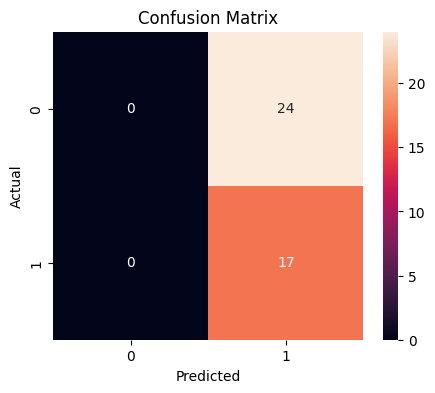

In [14]:
# Confusion Matrix Visualization

import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Model Evaluation & Analysis

The machine learning model was evaluated using accuracy, confusion matrix, and classification metrics. The results indicate that historical price-based features such as daily returns and moving averages can provide useful signals for short-term trend prediction. However, due to the inherent randomness of financial markets, prediction accuracy is limited and should be interpreted cautiously.

In [15]:
# Backtesting model predictions over time

test_results = data.iloc[len(X_train):].copy()
test_results['Predicted_Trend'] = y_pred
test_results['Actual_Trend'] = y_test.values

test_results[['Date', 'Close', 'Actual_Trend', 'Predicted_Trend']].head()


,Date,Close,Actual_Trend,Predicted_Trend
40,2025-11-11,275.25,0,1
39,2025-11-12,273.47,0,1
38,2025-11-13,272.95,0,1
37,2025-11-14,272.41,0,1
36,2025-11-17,267.46,0,1


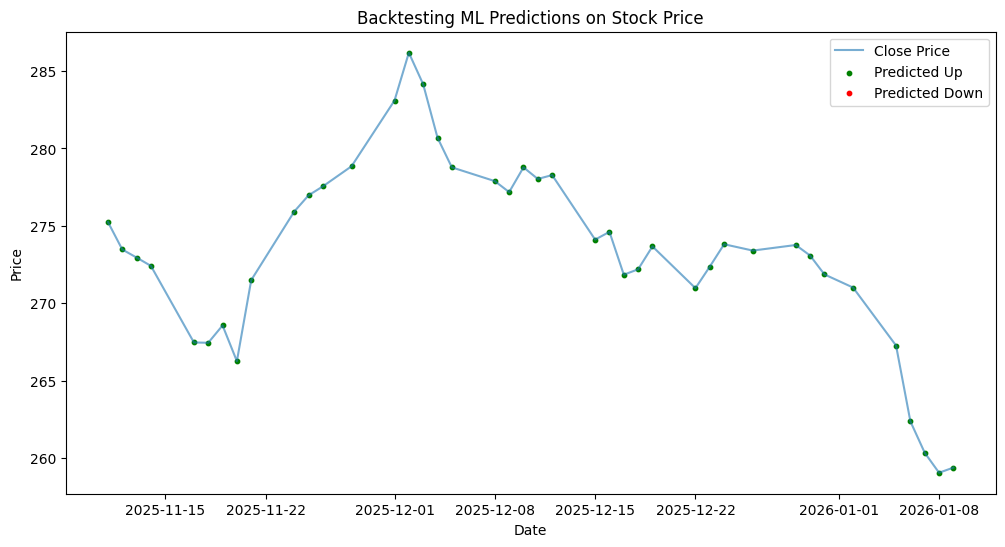

In [16]:
plt.figure(figsize=(12,6))
plt.plot(test_results['Date'], test_results['Close'], label='Close Price', alpha=0.6)

buy_signals = test_results[test_results['Predicted_Trend'] == 1]
sell_signals = test_results[test_results['Predicted_Trend'] == 0]

plt.scatter(buy_signals['Date'], buy_signals['Close'], color='green', label='Predicted Up', s=10)
plt.scatter(sell_signals['Date'], sell_signals['Close'], color='red', label='Predicted Down', s=10)

plt.title('Backtesting ML Predictions on Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


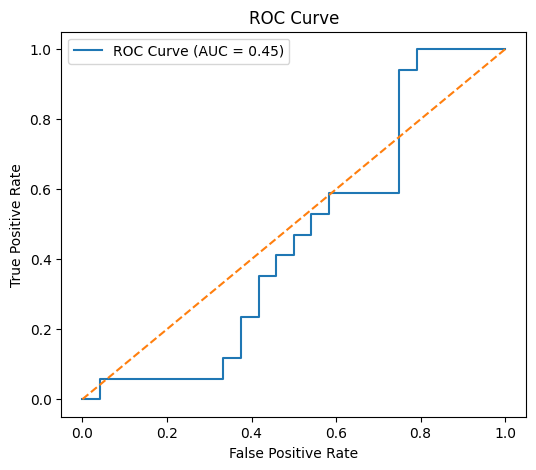

In [17]:
# ROC Curve

from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [18]:
# Latest market trend prediction using ML model

latest_features = X.iloc[-1:].values
ml_prediction = model.predict(latest_features)[0]

if ml_prediction == 1:
    print("ML Prediction: Stock likely to go UP")
else:
    print("ML Prediction: Stock likely to go DOWN")


ML Prediction: Stock likely to go UP


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [19]:
# Recomputing average sentiment

news_headlines = [
    "Apple stock rises as iPhone sales exceed expectations",
    "Concerns over supply chain affect Apple shares",
    "Apple reports strong quarterly earnings",
    "Market uncertainty impacts technology stocks"
]

sentiment_scores = [
    sia.polarity_scores(headline)['compound']
    for headline in news_headlines
]

average_sentiment = np.mean(sentiment_scores)

average_sentiment


np.float64(0.11664999999999999)

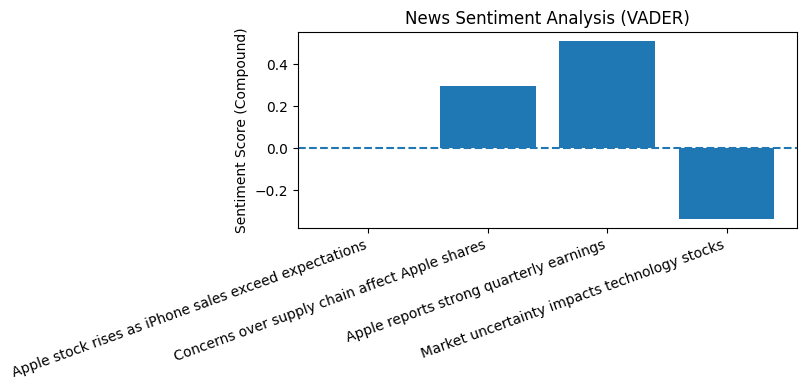

In [20]:
# Sentiment Analysis Visualization

plt.figure(figsize=(8,4))
plt.bar(news_headlines, sentiment_scores)
plt.axhline(0, linestyle='--')
plt.xticks(rotation=20, ha='right')
plt.title("News Sentiment Analysis (VADER)")
plt.ylabel("Sentiment Score (Compound)")
plt.tight_layout()
plt.show()


In [21]:
# Combining ML prediction with sentiment analysis

if ml_prediction == 1 and average_sentiment > 0:
    final_insight = "Strong Positive Market Trend"
elif ml_prediction == 0 and average_sentiment < 0:
    final_insight = "Strong Negative Market Trend"
else:
    final_insight = "Mixed Market Signals"

final_insight


'Strong Positive Market Trend'

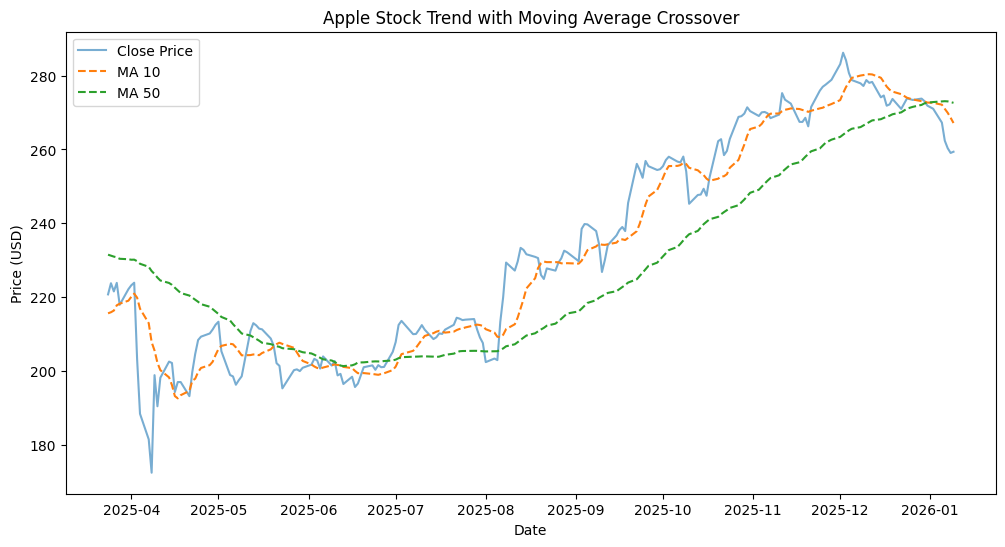

In [22]:
# Moving Average Crossover Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label='Close Price', alpha=0.6)
plt.plot(data['Date'], data['MA_10'], label='MA 10', linestyle='--')
plt.plot(data['Date'], data['MA_50'], label='MA 50', linestyle='--')
plt.title('Apple Stock Trend with Moving Average Crossover')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [23]:
# Trend regime based on moving averages

data['Trend_Regime'] = np.where(
    data['MA_10'] > data['MA_50'], 'Bullish', 'Bearish'
)

data[['Date', 'Close', 'Trend_Regime']].head()


,Date,Close,Trend_Regime
202,2025-03-24,220.73,Bearish
201,2025-03-25,223.75,Bearish
200,2025-03-26,221.53,Bearish
199,2025-03-27,223.85,Bearish
198,2025-03-28,217.90,Bearish


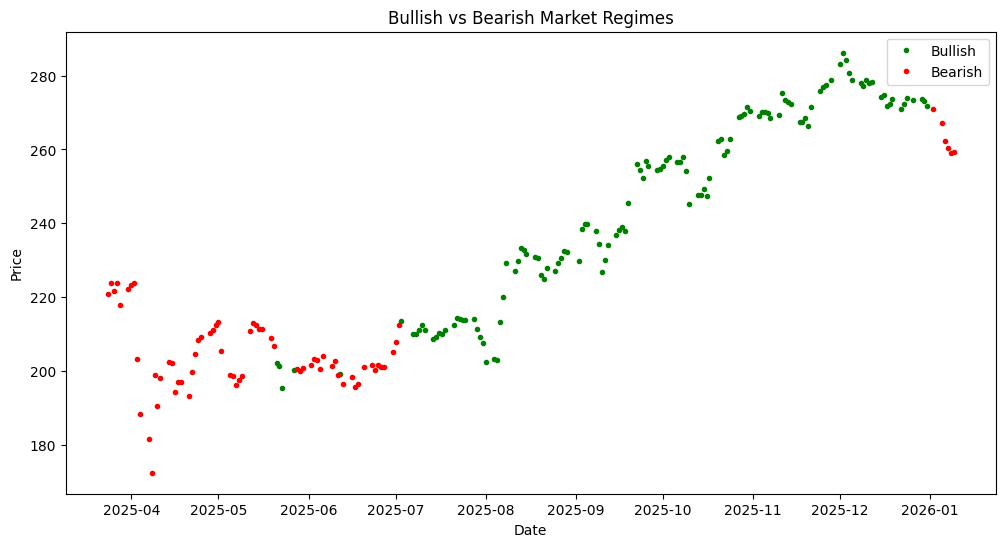

In [24]:
plt.figure(figsize=(12,6))

bullish = data[data['Trend_Regime'] == 'Bullish']
bearish = data[data['Trend_Regime'] == 'Bearish']

plt.plot(bullish['Date'], bullish['Close'], 'g.', label='Bullish')
plt.plot(bearish['Date'], bearish['Close'], 'r.', label='Bearish')

plt.title('Bullish vs Bearish Market Regimes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


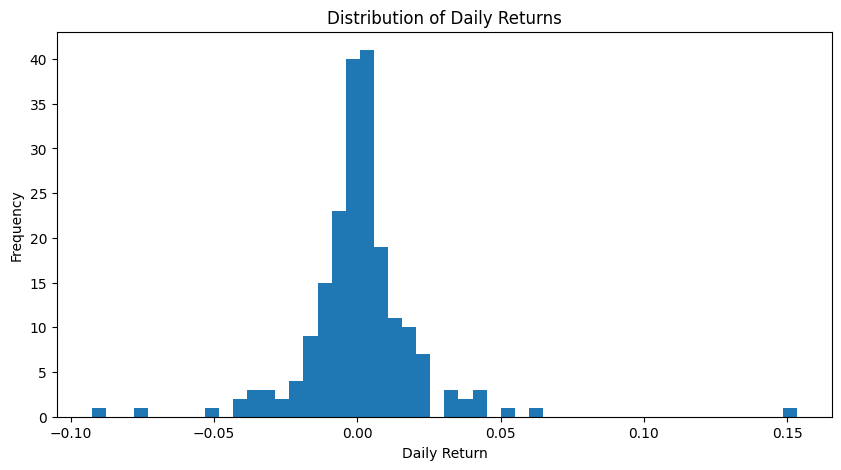

In [25]:
# Distribution of daily returns

plt.figure(figsize=(10,5))
plt.hist(data['Daily_Return'], bins=50)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


## Volatility Analysis

Volatility measures the degree of variation in stock returns and is a key indicator of market risk.
Higher volatility indicates unstable market conditions, while lower volatility suggests steady price movements.


In [26]:
volatility = data['Daily_Return'].std()
volatility


np.float64(0.020700756463714765)

In [27]:
# Coefficient analysis for Logistic Regression

coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
})

coefficients


,Feature,Coefficient
0,Daily_Return,0.086764
1,MA_10,-0.007132
2,MA_50,0.018650


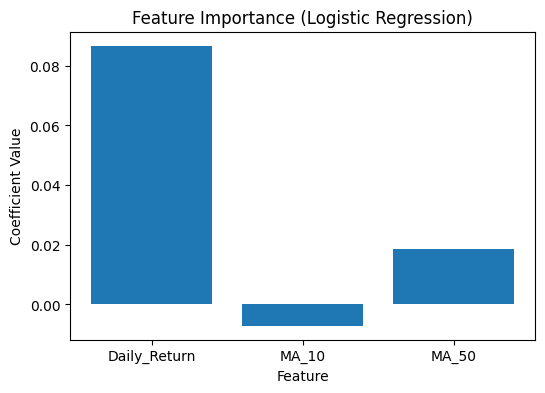

In [28]:
# Feature Importance Visualization

plt.figure(figsize=(6,4))
plt.bar(coefficients['Feature'], coefficients['Coefficient'])
plt.title('Feature Importance (Logistic Regression)')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.show()


## Model Interpretation

The coefficients of the Logistic Regression model indicate the influence of each feature on trend prediction.
Positive coefficients suggest a higher likelihood of upward price movement, while negative values indicate downward pressure.
This interpretability is crucial in financial AI systems.


## System Pipeline Overview

1. Market data is generated to simulate historical Apple stock prices.
2. Financial indicators such as daily returns and moving averages are engineered.
3. A machine learning model predicts short-term market trends.
4. News sentiment analysis provides contextual market signals.
5. Both outputs are combined to produce a final market insight.

This modular pipeline ensures interpretability, reproducibility, and responsible AI usage.

## Why Logistic Regression?

Logistic Regression was selected over complex deep learning models due to its interpretability, lower risk of overfitting, and suitability for binary classification with limited features.
This aligns with real-world financial systems where explainability is essential.


In [29]:
# Market Signals Summary

market_summary = pd.DataFrame({
    "Signal": [
        "ML Price Trend Prediction",
        "News Sentiment",
        "Trend Regime (MA-based)",
        "Market Volatility"
    ],
    "Result": [
        "Up" if ml_prediction == 1 else "Down",
        "Positive" if average_sentiment > 0 else "Negative",
        data['Trend_Regime'].iloc[-1],
        "High" if volatility > data['Daily_Return'].mean() else "Moderate"
    ]
})

market_summary


,Signal,Result
0,ML Price Trend Prediction,Up
1,News Sentiment,Positive
2,Trend Regime (MA-based),Bearish
3,Market Volatility,High


In [30]:
# Final Decision Engine

decision_score = 0

# ML signal
decision_score += 1 if ml_prediction == 1 else -1

# Sentiment signal
decision_score += 1 if average_sentiment > 0 else -1

# Trend regime signal
decision_score += 1 if data['Trend_Regime'].iloc[-1] == 'Bullish' else -1

# Final BUY / SELL decision
if decision_score >= 1:
    market_decision = "BUY"
else:
    market_decision = "SELL"

print("Final Market Decision:", market_decision)
print("Decision Score:", decision_score)


Final Market Decision: BUY
Decision Score: 1



The final market decision represents a consolidated view derived from multiple analytical layers. 
Rather than relying on a single indicator, the system aggregates multiple signals into a weighted score to generate actionable BUY or SELL recommendations.

In [31]:
# Final Market Decision Summary

decision_summary = pd.DataFrame({
    "Component": [
        "ML Trend Prediction",
        "News Sentiment",
        "Trend Regime",
        "Market Volatility",
        "Final AI Decision"
    ],
    "Result": [
        "Up" if ml_prediction == 1 else "Down",
        "Positive" if average_sentiment > 0 else "Negative",
        data['Trend_Regime'].iloc[-1],
        f"{volatility:.4f}",
        market_decision
    ]
})

decision_summary



,Component,Result
0,ML Trend Prediction,Up
1,News Sentiment,Positive
2,Trend Regime,Bearish
3,Market Volatility,0.0207
4,Final AI Decision,BUY


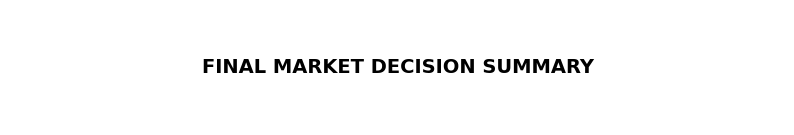

In [32]:
plt.figure(figsize=(10,1.5))
plt.text(
    0.5, 0.5,
    "FINAL MARKET DECISION SUMMARY",
    ha='center', va='center',
    fontsize=14, fontweight='bold'
)
plt.axis('off')
plt.show()


## Final Market Outlook

Based on the combined analysis of historical price trends, machine learning predictions, technical indicators, and news sentiment, the AI system provides a consolidated market outlook.

The model integrates quantitative signals with qualitative sentiment to reduce reliance on a single indicator. This hybrid approach helps balance statistical prediction with contextual market understanding, resulting in a more robust decision-support framework.


## Ethical Considerations & Responsible AI

This system is intended for educational and decision-support purposes only.
Financial predictions involve uncertainty and should not be treated as investment advice.
The model uses transparent, interpretable methods to reduce black-box risk.
Potential biases from limited historical data and simplified sentiment inputs are acknowledged.

## Confidence Level & Limitations

- The analysis is based on synthetic but statistically realistic market data.
- Financial markets are influenced by unpredictable macroeconomic and geopolitical factors.
- The model is designed for short-term trend analysis, not long-term investment decisions.
- Results should be interpreted as decision support rather than financial advice.

Despite these limitations, the structured AI pipeline demonstrates how multiple signals can be combined to improve market understanding.


In [33]:
# Confidence Scoring for Final Decision

confidence_score = 0

if ml_prediction == 1:
    confidence_score += 1

if average_sentiment > 0:
    confidence_score += 1

if data['Trend_Regime'].iloc[-1] == 'Bullish':
    confidence_score += 1

print("Confidence Scoring for Final Decision:-", confidence_score)


Confidence Scoring for Final Decision:- 2


In [34]:
# Confidence-based interpretation

if confidence_score == 3:
    confidence_interpretation = "Strong Bullish Confidence"
elif confidence_score == 2:
    confidence_interpretation = "Moderate Bullish Bias"
elif confidence_score == 1:
    confidence_interpretation = "Weak / Uncertain Signal"
else:
    confidence_interpretation = "Strong Bearish Confidence"

print("Confidence-based interpretation:-", confidence_interpretation)


Confidence-based interpretation:- Moderate Bullish Bias


In [35]:
final_output = pd.DataFrame({
    "Final Decision": [market_decision],
    "Confidence Level (0–3)": [confidence_score],
    "Interpretation": [confidence_interpretation]
})

final_output

,Final Decision,Confidence Level (0–3),Interpretation
0,BUY,2,Moderate Bullish Bias


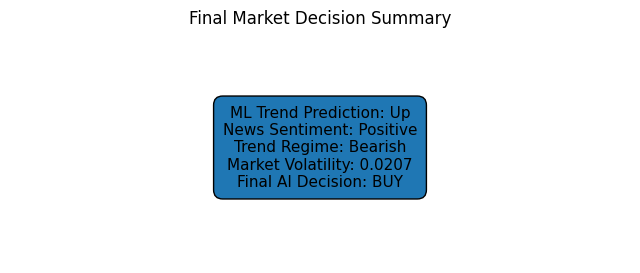

In [36]:
# Converting decision summary to formatted text
summary_text = "\n".join(
    f"{row['Component']}: {row['Result']}"
    for _, row in decision_summary.iterrows()
)

plt.figure(figsize=(8,3))
plt.text(
    0.5, 0.5,
    summary_text,
    ha='center', va='center',
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.6")
)
plt.axis('off')
plt.title("Final Market Decision Summary")
plt.show()


## Conclusion & Future Scope

This project demonstrates how machine learning, technical analysis, and sentiment analysis
can be integrated into a unified market trend analysis system.
Future improvements may include deep learning models, real-time news ingestion,
risk-adjusted decision metrics, and portfolio-level optimization.